In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

# Preparing the dataset
For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

Fill missing values with zeros.
Apply the log transform to median_house_value.
Do train/validation/test split with 60%/20%/20% distribution.
Use the train_test_split function and set the random_state parameter to 1.
Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [3]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = df[select_cols]
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [4]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [5]:
#@ INITIALIZING TRAINING FEATURES:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [6]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Question 1
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

ocean_proximity
total_rooms
latitude
population

In [7]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [8]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



<b>ocean_proximity</b> is the feature used for splitting the data

# Question 2
Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

0.045
0.245
0.545
0.845

In [9]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [10]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24579193759466622

<b>RMSE = 0.245</b>

# Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

10
25
50
160

In [11]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

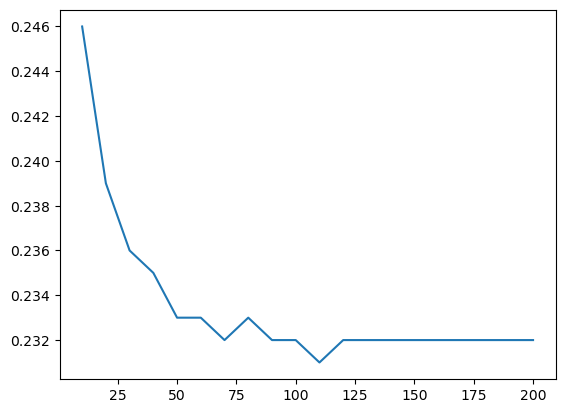

In [12]:
#@ INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

In [13]:
df_scores

,n_estimators,rmse
0,10,0.245792
1,20,0.239150
2,30,0.235651
3,40,0.234542
4,50,0.233054
5,60,0.232915
6,70,0.232499
7,80,0.232567
8,90,0.232220
9,100,0.231943


RMSE stops improving after <b>n_estimators = 70</b> (but goes down again after n_estimators = 80)

# Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?

10
15
20
25

In [14]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

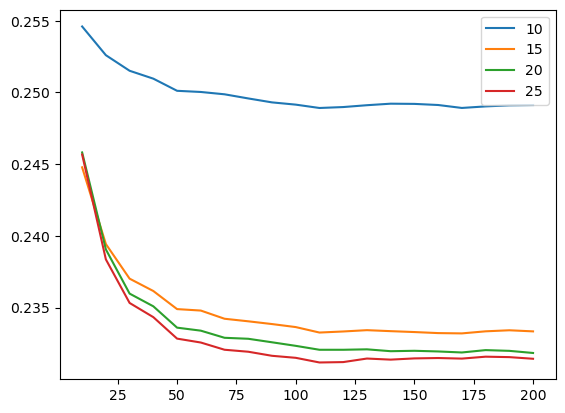

In [15]:
#@ PLOTTING THE GRAPH:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

<b>25</b> is the best max_depth as it gives the lowest RMSE values.